# Классификация изображений.

Будем работать с датасетом изображений. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.


In [1]:
!pip install wandb
!pip3 install pytorch_lightning torchmetrics

In [2]:
import math
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from pytorch_lightning.loggers import WandbLogger
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy
from torchvision.datasets import ImageFolder
from tqdm import tqdm

# You may add any imports you need

In [3]:
def seed_everything(seed):
    # Фискирует максимум сидов.
    # Это понадобится, чтобы сравнение оптимизаторов было корректным
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(123456)

In [4]:
!wget https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1 -O dataset.zip && unzip -q dataset.zip

--2022-11-03 15:08:12--  https://www.dropbox.com/s/33l8lp62rmvtx40/dataset.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/33l8lp62rmvtx40/dataset.zip [following]
--2022-11-03 15:08:12--  https://www.dropbox.com/s/dl/33l8lp62rmvtx40/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc11405adced277796d8c18e157d.dl.dropboxusercontent.com/cd/0/get/BwBlc0RRua2YEi6IHSDOrqiaIlcJLRpa-_TMF9IKH_606lOs5RkO_sR6YEPOlw_AD7Mkda3BHW7Uk5ohFapUzqWe1qcUYks-gSmT__BEQjTmbzPjtZuxeI9Esy1CLJE2iGpVOl5lpORY2FEvmpOsh7pQpguLvg2CplLaQ0HasmTzeQ/file?dl=1# [following]
--2022-11-03 15:08:13--  https://uc11405adced277796d8c18e157d.dl.dropboxusercontent.com/cd/0/get/BwBlc0RRua2YEi6IHSDOrqiaIlcJLRpa-_TMF9IKH_606lOs5RkO_sR6YEPOlw_AD7Mkda3BHW7Uk5

### Подготовка данных

Напишем свою сеть без использования готовых

In [4]:
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
import PIL

In [6]:
train_transform = Compose(
        [
            transforms.ColorJitter(hue=.05, saturation=.05),  # аугментация
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
val_transform = Compose(
        [ 
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )

train_dataset = ImageFolder('content/dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('content/dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

In [7]:
# Just very simple sanity checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [9]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

### Посмотрим на картиночки

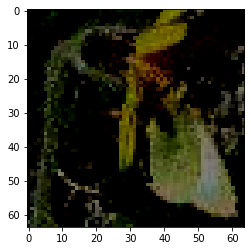

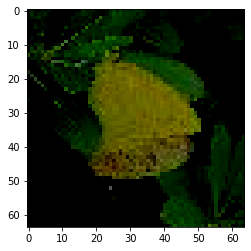

In [ ]:
for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break

In [7]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

Добьемся accuracy на валидации не менее 0.44.

### Модель

In [24]:
class YourNet(torch.nn.Module):
    def __init__(self, dropout=0.4):
        super().__init__()
        self.myverycoolnet = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(128, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Conv2d(128, 64, 3, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=dropout / 2), 
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Conv2d(128, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(), 
            
            torch.nn.Conv2d(256, 256, 3, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(), 
            torch.nn.Dropout(p=dropout / 2),
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=64 * 4 * 4 * 4, out_features=1000),
            torch.nn.Dropout(p=dropout),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=1000, out_features=200)
        )
        
        # --------------
        self.loss_func = torch.nn.CrossEntropyLoss()
        self.targets = torch.Tensor()
        self.preds = torch.Tensor()

    def _forward(self, x):
        # runs the neural network
        return self.myverycoolnet(x)

    def forward(self, images, target=None):
        # images ~ (batch size, num channels, height, width)
        # target ~ (batch size)
        # output ~ (batch size, num classes)
        output = self._forward(images)

        # get accuracy score and save it to self.accuracy
        if target is not None:
            loss = self.loss_func(output, target)
            
            self.targets = torch.cat((self.targets, target.cpu()), 0)
            pred = torch.argmax(output, dim=-1)
            self.preds = torch.cat((self.preds, pred.cpu()), 0)
            self.accuracy = accuracy(self.preds.long(), self.targets.long())

        return loss

    def get_accuracy(self, reset=False):
        # return accuracy by all values till now
        if reset:
            self.targets = torch.Tensor()
            self.preds = torch.Tensor()
        return self.accuracy

In [25]:
from collections import defaultdict, namedtuple

import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

LossInfo = namedtuple(
    "LossInfo",
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
# Гиперпараметры
EPOCHS = 20
LR = 0.0001

In [26]:
def train_epoch(
        model,
        data_loader,
        optimizer,
        return_losses=False,
        device="cuda:0",
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            # move Batch to GPU
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            # update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # update description for tqdm
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"100 * Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, device="cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for batch in data_loader:
            batch = [x.to(device=device) for x in batch]
            loss = model(*batch)
            accuracy = model.get_accuracy()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"100 * Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
    acc = model.get_accuracy(reset=True)
    metrics = {"loss": total_loss / num_batches, "accuracy": acc}
    return metrics

LossInfo = namedtuple(
    "LossInfo",
    ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"])

def fit(
        model,
        epochs,
        train_data_loader,
        validation_data_loader,
        optimizer,
        scheduler=None,
        device="cuda:0"
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            optimizer=optimizer,
            return_losses=True,
            device=device
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_iterator,
                device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [ ]:
model = YourNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
_ = fit(
    model=model,
    epochs=EPOCHS,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device
)

Train Epoch: 0
Loss: 4.4715 100 * Accuracy: 6.5: 100%|████████████████████████████████████████████| 1563/1563 [40:45<00:00,  1.56s/it]
Validation Epoch: 0
Loss: 3.3913 100 * Accuracy: 11.06: 100%|████████████████████████████████████████████| 157/157 [01:18<00:00,  1.99it/s]
Train Epoch: 1
Loss: 3.8506 100 * Accuracy: 15.644: 100%|█████████████████████████████████████████| 1563/1563 [41:12<00:00,  1.58s/it]
Validation Epoch: 1
Loss: 3.4322 100 * Accuracy: 16.83: 100%|████████████████████████████████████████████| 157/157 [01:20<00:00,  1.96it/s]
Train Epoch: 2
Loss: 3.1897 100 * Accuracy: 23.702: 100%|█████████████████████████████████████████| 1563/1563 [41:18<00:00,  1.59s/it]
Validation Epoch: 2
Loss: 3.0089 100 * Accuracy: 21.6: 100%|█████████████████████████████████████████████| 157/157 [01:19<00:00,  1.98it/s]
Train Epoch: 3
Loss: 2.6898 100 * Accuracy: 30.12: 100%|██████████████████████████████████████████| 1563/1563 [41:06<00:00,  1.58s/it]
Validation Epoch: 3
Loss: 2.5146 100 * A

In [ ]:
def evaluate_task(model, test_dataloader, device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")):
    model = model.to(device)
    model.eval()
    accuracy = 0.0
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            loss = model(images, labels)
            acc_batch = model.get_accuracy(reset=False)
        accuracy += acc_batch
    accuracy = accuracy / len(test_dataloader)
    return accuracy

In [ ]:
accuracy = evaluate_task(model, val_dataloader)

In [ ]:
accuracy

tensor(0.2943)

In [ ]:
# Видно, что модель сильно переобучается, так как на трейне accuracy почти 100%, а на тесте всего 30%, попробуем добавить
# больше регуляризации (P.S. не вышло, помогло убрать scheduler)

In [28]:
model03 = YourNet().to(device)
optimizer = torch.optim.Adam(model03.parameters(), LR)
_ = fit(
    model=model03,
    epochs=17,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    optimizer=optimizer,
    device=device
)

Train Epoch: 0
Loss: 4.0985 100 * Accuracy: 6.332: 100%|██████████| 1563/1563 [08:52<00:00,  2.93it/s]
Validation Epoch: 0
Loss: 3.4059 100 * Accuracy: 10.97: 100%|██████████| 157/157 [00:09<00:00, 17.09it/s]
Train Epoch: 1
Loss: 4.3004 100 * Accuracy: 15.344: 100%|██████████| 1563/1563 [08:37<00:00,  3.02it/s]
Validation Epoch: 1
Loss: 2.5829 100 * Accuracy: 16.61: 100%|██████████| 157/157 [00:09<00:00, 16.89it/s]
Train Epoch: 2
Loss: 3.5972 100 * Accuracy: 20.781: 100%|██████████| 1563/1563 [08:44<00:00,  2.98it/s]
Validation Epoch: 2
Loss: 2.0155 100 * Accuracy: 18.61: 100%|██████████| 157/157 [00:09<00:00, 16.96it/s]
Train Epoch: 3
Loss: 3.3809 100 * Accuracy: 24.607: 100%|██████████| 1563/1563 [08:36<00:00,  3.03it/s]
Validation Epoch: 3
Loss: 2.0222 100 * Accuracy: 22.84: 100%|██████████| 157/157 [00:09<00:00, 16.94it/s]
Train Epoch: 4
Loss: 2.8944 100 * Accuracy: 27.843: 100%|██████████| 1563/1563 [08:38<00:00,  3.02it/s]
Validation Epoch: 4
Loss: 2.2708 100 * Accuracy: 25.71: 1

In [ ]:
accuracy = evaluate_task(model, val_dataloader)

In [32]:
accuracy

tensor(0.4149)

In [ ]:
# Интересно, но без scheduler'а все обучилось гораздо лучше. Полагаю на бОльшем количестве итераций можно качество
# добить и до 0.44

Добьемся accuracy на валидации не менее 0.84.

In [9]:
train_transform = Compose(
        [
            Resize((224, 224)),  # так как в ImageNet были картинки 224*224
            # мы же будем дообучать ImageNet
            transforms.ColorJitter(hue=.05, saturation=.05),  # аугментация
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )
val_transform = Compose(
        [
            Resize((224, 224)),  
            ToTensor(), 
            Normalize((0.5, 0.5, 0.5), (1, 1, 1)), 
        ]
    )

train_dataset = ImageFolder('dataset/dataset/train', transform=train_transform)
val_dataset = ImageFolder('dataset/dataset/val', transform=val_transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

### Тренировочный класс lightning

In [10]:
import pytorch_lightning as pl
from torchmetrics.functional import accuracy
from torchvision.models import resnet18

In [ ]:
# First try

In [ ]:
resnet18(pretrained=True) # используем предобученную модель

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class YourModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.model.fc = nn.Identity() # выходной слой ResNet'а убираем
        self.classifier = nn.Linear(512, 200)  # добавляем новый нужный нам выходной слой
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr = learning_rate) # оптимизатор для последнего слоя

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad(): # градиенты считать не будем, так как в ImageNet мы ничего не меняем
            features = self.model(x)
        preds = self.classifier(features) 
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True)
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
image_net_pretrained = YourModule(resnet18(pretrained=True), 0.0001)

trainer = pl.Trainer(
    accelerator="cpu",
    max_epochs=20
)

trainer.fit(image_net_pretrained, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 11.2 M
1 | classifier | Linear           | 102 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
11.3 M    Trainable params
0         Non-trainable params
11.3 M    Total params
45.116    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Public\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Public\Anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Валидация результатов 

In [12]:
from sklearn.metrics import accuracy_score

def eval_task(model, test_dataloader, device="cuda"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
model1 = image_net_pretrained

accuracy = eval_task(model1, val_dataloader)

In [ ]:
accuracy

0.5746

In [ ]:
# Такой резнет плох, попробуем другие предобученные архитектуры, например resnet побольше:

In [ ]:
from torchvision.models import resnet152

In [ ]:
resnet152(pretrained=True)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
class YourModule1(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.model.fc = nn.Identity() # выходной слой ResNet'а убираем
        self.classifier = nn.Linear(2048, 200)  # добавляем новый нужный нам выходной слой
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.classifier.parameters(), lr = learning_rate) # оптимизатор для последнего слоя

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad(): # градиенты считать не будем, так как в ImageNet мы ничего не меняем
            features = self.model(x)
        preds = self.classifier(features) 
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True) 
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
image_net_pretrained1 = YourModule1(resnet152(pretrained=True), 0.001)

trainer = pl.Trainer(
    accelerator="cuda",
    max_epochs=1
)

trainer.fit(image_net_pretrained1, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | model      | ResNet           | 58.1 M
1 | classifier | Linear           | 409 K 
2 | loss       | CrossEntropyLoss | 0     
------------------------------------------------
58.6 M    Trainable params
0         Non-trainable params
58.6 M    Total params
234.214   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
from sklearn.metrics import accuracy_score

def eval_task(model, test_dataloader, device="cuda"):
    model = model.to(device)
    predicted_classes = torch.Tensor([]).to(device)
    true_classes = torch.Tensor([]).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)

            pred = model.forward(images)
            pred_classes = torch.argmax(pred, dim=-1)

            predicted_classes = torch.cat((predicted_classes, pred_classes), 0)
            true_classes = torch.cat((true_classes, labels), 0)

    return accuracy_score(predicted_classes.cpu().detach().numpy(), true_classes.cpu().detach().numpy())

In [ ]:
model2 = image_net_pretrained1

accuracy = eval_task(model2, val_dataloader)

In [ ]:
accuracy

0.6338

In [ ]:
# Эта модель явно лучше, так как дает результат лучше с одной эпохи (резнет18 я обучал 20 эпох)
# Будем дальше перебирать модели из torchvision.models

In [ ]:
from torchvision.models import efficientnet_v2_m

In [ ]:
efficientnet_v2_m(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
class YourModule2(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.model.classifier = nn.Identity() # выходной слой efficientnet_v2_m'а убираем
        self.clas = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(1280, 200)
          )  # добавляем новый нужный нам выходной слой
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.clas.parameters(), lr = learning_rate) # оптимизатор для последнего слоя

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad(): # градиенты считать не будем, так как в ImageNet мы ничего не меняем
            features = self.model(x)
        preds = self.clas(features) 
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True) 
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
image_net_pretrained3 = YourModule2(efficientnet_v2_m(pretrained=True), 0.001)

trainer = pl.Trainer(
    accelerator="cuda",
    max_epochs=1
)

trainer.fit(image_net_pretrained3, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | EfficientNet     | 52.9 M
1 | clas  | Sequential       | 256 K 
2 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
53.1 M    Trainable params
0         Non-trainable params
53.1 M    Total params
212.458   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
model3 = image_net_pretrained3

accuracy = eval_task(model3, val_dataloader)

In [ ]:
accuracy

0.6605

In [ ]:
# Ту же сетку на бОльшее количество эпох
image_net_pretrained4 = YourModule2(efficientnet_v2_m(pretrained=True), 0.0005)

trainer = pl.Trainer(
    accelerator="cuda",
    max_epochs=5
)

trainer.fit(image_net_pretrained4, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | EfficientNet     | 52.9 M
1 | clas  | Sequential       | 256 K 
2 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
53.1 M    Trainable params
0         Non-trainable params
53.1 M    Total params
212.458   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model4 = image_net_pretrained4

accuracy = eval_task(model4, val_dataloader)

In [ ]:
accuracy

0.6725

In [ ]:
# На последующих эпохах слабо растет, продолжим подбор

In [ ]:
from torchvision.models import vit_b_16

In [ ]:
vit_b_16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [ ]:
class YourModule3(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.model.heads = nn.Identity() # выходной слой VIT'а убираем
        self.clas = nn.Sequential(
            nn.Linear(768, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(200, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 200)
            ) # добавляем новый нужный нам выходной слой
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.clas.parameters(), lr = learning_rate) # оптимизатор для последнего слоя

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad(): # градиенты считать не будем, так как в ImageNet мы ничего не меняем
            features = self.model(x)
        preds = self.clas(features) 
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True) 
        self.log("accuracy", acc, prog_bar=True)

In [ ]:
image_net_pretrained5 = YourModule3(vit_b_16(pretrained=True), 0.0005)

trainer = pl.Trainer(
    accelerator="cuda",
    max_epochs=3
)

trainer.fit(image_net_pretrained5, train_dataloader, val_dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, u

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [ ]:
model5 = image_net_pretrained5

accuracy = eval_task(model5, val_dataloader)

In [ ]:
accuracy

0.7554

In [ ]:
# Уже хорошо, подгрузим более тяжелую VIT модель

In [13]:
from torchvision.models import vit_l_16

In [14]:
vit_l_16(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_l_16-852ce7e3.pth" to /root/.cache/torch/hub/checkpoints/vit_l_16-852ce7e3.pth


  0%|          | 0.00/1.13G [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (

In [15]:
class YourModule4(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model
        self.model.heads = nn.Identity() # выходной слой VIT'а убираем
        self.clas = nn.Sequential(
            nn.Linear(1024, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(200, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 200)
            ) # добавляем новый нужный нам выходной слой
        self.lr = learning_rate
        self.optimizer = torch.optim.Adam(self.clas.parameters(), lr = learning_rate) # оптимизатор для последнего слоя

        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        with torch.no_grad(): # градиенты считать не будем, так как в ImageNet мы ничего не меняем
            features = self.model(x)
        preds = self.clas(features) 
        return preds

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx):
        images, target = train_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        images, target = val_batch
        preds = self.forward(images)
        loss = self.loss(preds, target)
        acc = accuracy(torch.argmax(preds, dim=-1).long(), target.long())
        self.log("val_loss", loss, prog_bar=True) 
        self.log("accuracy", acc, prog_bar=True)

In [17]:
image_net_pretrained6 = YourModule4(vit_l_16(pretrained=True), 0.0005)

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=1
)

trainer.fit(image_net_pretrained6, train_dataloader, val_dataloader)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ViT_L_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_L_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, u

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Одна эпоха на gpu обучалась 1:20:00, поэтому не буду ставить на больше, но понятно, что качество можно немного и повысить

In [ ]:
model6 = image_net_pretrained6

accuracy = eval_task(model6, val_dataloader)

In [20]:
accuracy

0.792